# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
!python3 -m pip install datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [ ]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [ ]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
vocabulary = vocab(
    Counter(token for text in tqdm(train_df["text"]) for token in tokenizer(text)),
    min_freq=10,
    specials=["<unk>", "<pad>"])
vocabulary.set_default_index(vocabulary["<unk>"])

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [8]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

In [9]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [10]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  39, 4850,   11,  265,  646,    8,   27,   27,   27,    0])

In [ ]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [12]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]
        max_len = max([len(x) for x in batch_X])
        batch_X = torch.stack(
            [
                torch.cat([torch.ones(max_len - len(x), dtype=torch.long) * pad_id, x])
                for x in batch_X
            ]
        )
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [13]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

We decided to add padding tokens before the sequence. Initially, we added them at the end, but the RNN was not learning anything. This is due to the fact the model tends to forget the first elements of the sequence, thus only remembering padding tokens. By adding padding tokens at the beginning, we make sure the model will not forget the meaningful elements of the sequence.

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember, an RNN has 3 elements.
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [14]:
class RNN(nn.Module):
    def __init__(self, vocabulary_size: int, embedding_size: int, hidden_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.W = nn.Linear(embedding_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        self.activation = nn.Tanh()

    def forward(self, x: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        """
        Return the output of the RNN as well as the new hidden layer. Return logits.
        """
        x = self.embedding(x)
        x = self.W(x)
        x = self.activation(x + self.U(hidden))
        hidden = x
        x = self.V(x)
        return x, hidden

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        return torch.zeros(batch_size, self.U.in_features)

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

0it [00:00, ?it/s]

end of EPOCH loss : 0.667121111869812


0it [00:00, ?it/s]

Epoch 1/10: train_loss=0.667, valid_loss=0.640


0it [00:00, ?it/s]

end of EPOCH loss : 0.6310531867980957


0it [00:00, ?it/s]

Epoch 2/10: train_loss=0.631, valid_loss=0.624


0it [00:00, ?it/s]

end of EPOCH loss : 0.5961845139980316


0it [00:00, ?it/s]

Epoch 3/10: train_loss=0.596, valid_loss=0.624


0it [00:00, ?it/s]

end of EPOCH loss : 0.594816054201126


0it [00:00, ?it/s]

Epoch 4/10: train_loss=0.595, valid_loss=0.694


0it [00:00, ?it/s]

end of EPOCH loss : 0.5469777703285217


0it [00:00, ?it/s]

Epoch 5/10: train_loss=0.547, valid_loss=0.552


0it [00:00, ?it/s]

end of EPOCH loss : 0.49112706089019775


0it [00:00, ?it/s]

Epoch 6/10: train_loss=0.491, valid_loss=0.560


0it [00:00, ?it/s]

end of EPOCH loss : 0.4580794419527054


0it [00:00, ?it/s]

Epoch 7/10: train_loss=0.458, valid_loss=0.521


0it [00:00, ?it/s]

end of EPOCH loss : 0.44978069348335264


0it [00:00, ?it/s]

Epoch 8/10: train_loss=0.450, valid_loss=0.554


0it [00:00, ?it/s]

end of EPOCH loss : 0.4108046042919159


0it [00:00, ?it/s]

Epoch 9/10: train_loss=0.411, valid_loss=0.493


0it [00:00, ?it/s]

end of EPOCH loss : 0.4120250194311142


0it [00:00, ?it/s]

Epoch 10/10: train_loss=0.412, valid_loss=0.504


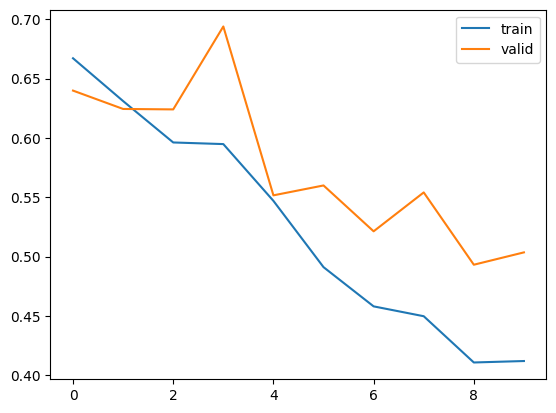

In [17]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

n_epochs = 10
best_loss = np.inf
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss = length = 0

    for batch_X, batch_y in tqdm(train_gen()):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        hidden = model.init_hidden(batch_size=batch_X.shape[0]).to(device)
        optimizer.zero_grad()
        for i in range(batch_X.shape[1]):
            output, hidden = model(batch_X[:, i], hidden)
        loss = criterion(output, batch_y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        length += 1

    train_loss /= length
    train_losses.append(train_loss)

    model.eval()
    valid_loss = length = 0
    with torch.no_grad():
        for batch_X, batch_y in tqdm(valid_gen()):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            hidden = model.init_hidden(batch_size=batch_X.shape[0]).to(device)
            for i in range(batch_X.shape[1]):
                output, hidden = model(batch_X[:, i], hidden)
            loss = criterion(output, batch_y.float().unsqueeze(1))
            valid_loss += loss.item()
            length += 1

        valid_loss /= length
        valid_losses.append(valid_loss)

    print(
        f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}"
    )
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")

plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.legend()
plt.show()

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [18]:
def compute_accuracy(
    model: nn.Module,
    data_gen: Callable[[], Generator[Tuple[torch.Tensor, torch.Tensor], None, None]],
) -> float:
    """
    Compute the accuracy of the model on the given data.
    Args:
        model: the model to evaluate.
        data_gen: a data generator which yields batches of data.
    Returns:
        The accuracy of the model on the data.
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch_X, batch_y in data_gen():
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            hidden = model.init_hidden(batch_size=batch_X.shape[0]).to(device)
            for i in range(batch_X.shape[1]):
                output, hidden = model(batch_X[:, i], hidden)
            y_true.extend(batch_y.tolist())
            y_pred.extend(torch.sigmoid(output.squeeze()).round().tolist())
    return accuracy_score(y_true, y_pred)

In [19]:
model.load_state_dict(torch.load("best_model.pt"))
train_acc = compute_accuracy(model, train_gen)
valid_acc = compute_accuracy(model, valid_gen)
test_acc = compute_accuracy(model, test_gen)
print(
    f"Train accuracy: {train_acc:.3f}, valid accuracy: {valid_acc:.3f}, test accuracy: {test_acc:.3f}"
)

Train accuracy: 0.824, valid accuracy: 0.778, test accuracy: 0.774


Results:
- Train accuracy: 0.824
- Valid accuracy: 0.778
- Test accuracy: 0.774

We see that already with 10 epochs, the RNN tends to overfit. We still reach a good overall accuracy.